# 機械学習をPythonで実践する-11　　～ XGBoost ～
eXtreme Gradient Boostingの略。  
参考：https://datawokagaku.com/xgboost/

In [304]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, label_binarize
# import statsmodels.api as sma
from sklearn.model_selection import train_test_split ,LeaveOneOut, cross_val_score, KFold, RepeatedKFold,StratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, log_loss, confusion_matrix,ConfusionMatrixDisplay, \
accuracy_score, precision_score, recall_score,precision_recall_curve,f1_score,roc_curve,auc,get_scorer_names
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage,dendrogram,fcluster
from sklearn import tree

%matplotlib inline
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## ○ XGBoostで分類
pipでxgboostをインストールする必要あり。  
xgboostライブラリからXGBClassifierをインポートして分類を行う。  
基本的な使い方はscikit-learnの各モデルと同じ。インスタンス生成してfitで学習する。  
分類器XGBClassifier()インスタンス生成時のパラメータは下記。  
* n_estimators : ブースティングの回数(=学習する決定木の数)．デフォルトは100．
* learning_rate : shrinkageのη．デフォルトは0.3。
* max_depth : 決定木の最高の深さ．デフォルトは6
* eval_metric : ブースティング時の各イテレーション時に使う評価指標(特に後述するearly stoppingに使用). sklearn.metricsのメソッドを渡すか，自作してもOK．デフォルトは 'logloss'
* early_stopping_rounds : early stoppingする際の，最低限ブースティングのイテレーションをする回数  

early stoppingとは、ブースティングのイテレーション時に評価指標がそれ以上上がらなくなったら自動で学習をやめてくれること。  

In [ ]:
# xgboostをインストール。scikit-learnには入っていない。
%pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 1.9 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [107]:
# xgboostをインポート
from xgboost import XGBClassifier
import xgboost as xgb

In [95]:
# seabornのtitanicデータセットをインポート
df = sns.load_dataset('titanic')

In [96]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


<b>★重要  
XGBoostは欠損値に対処するアルゴリズムが組み込まれているため、欠損値（NaN）をdropする必要はなく、  
欠損値があるデータをそのままモデルに学習させることができる。</b>  
欠損値に別途値を代入してからXGBoostを学習させてもよいが、XGBoostを使う場合は欠損値対応はせずに、  
そのまま学習させることが多い。もし、欠損値のデータをdropすると学習データが減ってしまい一般的に精度が下がる。  

In [303]:
# 目的変数の割合を確認
df['survived'].value_counts()

0    549
1    342
Name: survived, dtype: int64

死者の方が多い。

In [261]:
# survivedとalive以外を特徴量にする。.dropnaをする必要はない。
X = df.loc[:, (df.columns != 'survived') &  (df.columns != 'alive')]
X = pd.get_dummies(X, drop_first=True)
y = df['survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=0)

In [289]:
# XGBoostで学習。
model = XGBClassifier(early_stopping_rounds=10, learning_rate=0.1)#, alpha=5)
# .fitのeval_setに(X,y)を渡すと、ブースティング時の各イテレーションごとにこのデータセットで評価(今回はlogloss)してくれる。
# この評価はearly stoppingの判定基準のこと。
# 今回は本来のテストデータを検証データに使用。検証データに過学習気味になるので別途汎化性能を確かめた方が良い。
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=True)

[0]	validation_0-logloss:0.64774
[1]	validation_0-logloss:0.61109
[2]	validation_0-logloss:0.58059
[3]	validation_0-logloss:0.55464
[4]	validation_0-logloss:0.53387
[5]	validation_0-logloss:0.51710
[6]	validation_0-logloss:0.50228
[7]	validation_0-logloss:0.49012
[8]	validation_0-logloss:0.47901
[9]	validation_0-logloss:0.47070
[10]	validation_0-logloss:0.46297
[11]	validation_0-logloss:0.45603
[12]	validation_0-logloss:0.45033
[13]	validation_0-logloss:0.44547
[14]	validation_0-logloss:0.44080
[15]	validation_0-logloss:0.43653
[16]	validation_0-logloss:0.43411
[17]	validation_0-logloss:0.43146
[18]	validation_0-logloss:0.42979
[19]	validation_0-logloss:0.42736
[20]	validation_0-logloss:0.42457
[21]	validation_0-logloss:0.42280
[22]	validation_0-logloss:0.42120
[23]	validation_0-logloss:0.41939
[24]	validation_0-logloss:0.41859
[25]	validation_0-logloss:0.41663
[26]	validation_0-logloss:0.41589
[27]	validation_0-logloss:0.41614
[28]	validation_0-logloss:0.41452
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

XGBoostの場合、.fitはモデル自体も返してくる。  
本来100回イテレーションを行うはずだが、[34]回目にloglossが最小になっているので、  
early-stoppingにより、44回目で学習を終了する。

In [290]:
# 最終的なlog-lossを確認
y_pred = model.predict_proba(X_test)
log_loss(y_test,y_pred)

0.4096059097574829

In [291]:
accuracy_score(y_test, model.predict(X_test))

0.8059701492537313

普通の決定木による分類の方がわずかに精度が良い結果となった。(ML_notebook-9)  
こちらはX_testを既に学習の参考データ(early stopping用)として使っているので、フェアな評価ではない。（もっと高くあるべき・・・）  

In [292]:
# こっちでもaccuracy確認可能。
model.score(X_test, y_test)

0.8059701492537313

In [293]:
model.score(X_train, y_train)

0.8956661316211878

scoreを見てみると学習データでの精度が高く、過学習気味になっている可能性あり。  

In [297]:
# k-fold CVしてみる
from xgboost import cv
data_dmatrix = xgb.DMatrix(data=X, label=y)

params = {"objective":"binary:logistic",'learning_rate': 0.1}
                #'max_depth': 5, 'alpha': 5}

# xgboostのcvメソッドでk-fold CV可能
xgb_cv = cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=50, early_stopping_rounds=10, metrics="logloss", as_pandas=True)

In [299]:
xgb_cv[-10:]

,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
20,0.317210,0.005644,0.433656,0.029206
21,0.312102,0.005606,0.432602,0.029698
22,0.307537,0.005243,0.431100,0.030471
23,0.303419,0.005595,0.430276,0.031128
24,0.299577,0.005482,0.429260,0.031215
25,0.296104,0.005676,0.428953,0.031663
26,0.292589,0.005791,0.428614,0.031892
27,0.289508,0.005882,0.428800,0.032381
28,0.286670,0.005877,0.428790,0.032563
29,0.283517,0.005397,0.428170,0.032806


k-fold CVの結果(test-logloss-mean)と学習結果のlog-lossには大きな乖離はないので、  
上記の学習の中で検証データ(X_test)に過学習しているわけではなさそう。  
もし過学習しているのであれば学習したモデルのlog-lossが圧倒的に良くなるはず。  
ただ、学習データには過学習気味になっていそう。

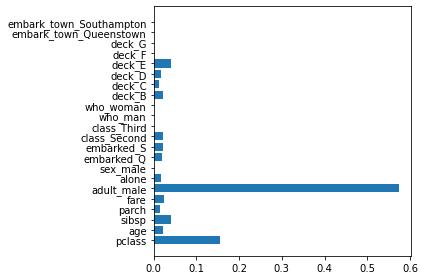

In [294]:
# 特徴量の重要度を表示
plt.barh(X.columns, model.feature_importances_)
plt.tight_layout()

In [329]:
# xgbのcvメソッドを使わない場合のk-Fold CV。Staratifiedすることでfoldごとに含まれるクラスの割合を等しくした状態でCVできる。
# 各モデルの学習結果を詳細に見たいときはこっちの方が良いかも。
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
logloss_list = []
class_ratio = {}
model_cv =  XGBClassifier(early_stopping_rounds=10, learning_rate=0.1)

for train_index, test_index in kf.split(X ,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # モデル学習
    eval_set = [(X_test, y_test)]
    model_cv.fit(X_train, y_train, eval_set=eval_set, verbose=True)
    # テストデータに対する予測値算出
    y_pred = model_cv.predict_proba(X_test)
    
    # logloss
    logloss = log_loss(y_test, y_pred)
    logloss_list.append(logloss)

[0]	validation_0-logloss:0.64252
[1]	validation_0-logloss:0.60088
[2]	validation_0-logloss:0.56674
[3]	validation_0-logloss:0.53983
[4]	validation_0-logloss:0.51819
[5]	validation_0-logloss:0.49910
[6]	validation_0-logloss:0.48321
[7]	validation_0-logloss:0.46934
[8]	validation_0-logloss:0.45721
[9]	validation_0-logloss:0.44709
[10]	validation_0-logloss:0.43636
[11]	validation_0-logloss:0.42938
[12]	validation_0-logloss:0.42269
[13]	validation_0-logloss:0.41596
[14]	validation_0-logloss:0.41027
[15]	validation_0-logloss:0.40440
[16]	validation_0-logloss:0.40053
[17]	validation_0-logloss:0.39718
[18]	validation_0-logloss:0.39298
[19]	validation_0-logloss:0.39069
[20]	validation_0-logloss:0.38766
[21]	validation_0-logloss:0.38580
[22]	validation_0-logloss:0.38429
[23]	validation_0-logloss:0.38304
[24]	validation_0-logloss:0.38242
[25]	validation_0-logloss:0.38137
[26]	validation_0-logloss:0.38072
[27]	validation_0-logloss:0.38065
[28]	validation_0-logloss:0.38132
[29]	validation_0-loglos

In [319]:
logloss_list

[0.38007898139637275,
 0.3898835586949011,
 0.40917928223864414,
 0.43595871952979753,
 0.489067702648345]

In [327]:
np.mean(logloss_list)

0.4208336489016121

xgbのcvメソッドの結果と概ね同じ。こっちの方が計算量は多いが、わかりやすいかも。